In [5]:
# USAGE
# python train_mask_detector.py --dataset dataset

# import the necessary packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import cv2
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [6]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images("C:/Users/JHChen/OneDrive/文件/tsaiyaju/碩一上/樣形識別/knife-Detector-master/dataset"))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]

    # load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

[INFO] loading images...


In [7]:
len(labels)

12899

In [8]:
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)


In [9]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [10]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [11]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.25,
    width_shift_range=0.3,
    height_shift_range=0.4,
    shear_range=0.35,
    horizontal_flip=True,
    fill_mode="nearest")


In [12]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

/Users/inmatin/Library/Python/3.7/lib/python/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [13]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

[INFO] compiling model...


In [14]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(aug.flow(trainX, trainY, batch_size=BS),steps_per_epoch=len(trainX) // BS,validation_data=(testX, testY),validation_steps=len(testX) // BS,epochs=EPOCHS)


[INFO] training head...
Epoch 1/20
322/322 [==============================] - 514s 2s/step - loss: 0.5058 - accuracy: 0.7589 - val_loss: 0.3560 - val_accuracy: 0.8492
Epoch 2/20
322/322 [==============================] - 534s 2s/step - loss: 0.3699 - accuracy: 0.8325 - val_loss: 0.3497 - val_accuracy: 0.8508
Epoch 3/20
322/322 [==============================] - 495s 2s/step - loss: 0.3425 - accuracy: 0.8478 - val_loss: 0.3004 - val_accuracy: 0.8678
Epoch 4/20
322/322 [==============================] - 491s 2s/step - loss: 0.3354 - accuracy: 0.8579 - val_loss: 0.3156 - val_accuracy: 0.8632
Epoch 5/20
322/322 [==============================] - 518s 2s/step - loss: 0.3204 - accuracy: 0.8632 - val_loss: 0.2754 - val_accuracy: 0.8864
Epoch 6/20
322/322 [==============================] - 523s 2s/step - loss: 0.3143 - accuracy: 0.8641 - val_loss: 0.2966 - val_accuracy: 0.8744
Epoch 7/20
322/322 [==============================] - 498s 2s/step - loss: 0.3017 - accuracy: 0.8684 - val_loss: 0.287

In [15]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("model.h5")


[INFO] evaluating network...
               precision    recall  f1-score   support

NEGATIVES_ALL       0.94      0.93      0.93      1868
POSITIVES_ALL       0.82      0.84      0.83       712

     accuracy                           0.90      2580
    macro avg       0.88      0.89      0.88      2580
 weighted avg       0.91      0.90      0.90      2580

[INFO] saving mask detector model...


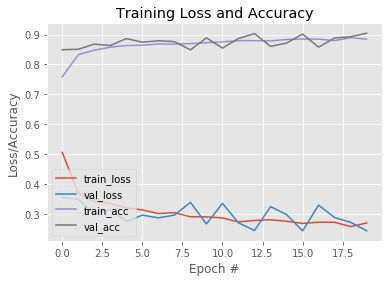

In [16]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plt.png")

In [20]:
model = tf.keras.models.load_model("model.h5")

In [21]:
def encoding(path):
    face = plt.imread(path)
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    face = cv2.resize(face, (224, 224))
    face = img_to_array(face)
    face = preprocess_input(face)
    face = np.expand_dims(face, axis=0)
    return face

In [55]:
def prediction(image):
    encode_image = encoding(image)
    (no_knife,knife) = model.predict(encode_image)[0]
    if knife>no_knife:
        return "knife",knife
    else:
        return "no_knife",no_knife
    

('knife', 0.96831036)

In [63]:
img = plt.imread("download (2).jpeg")

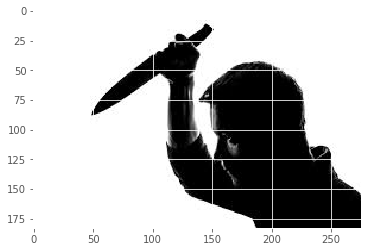

In [69]:
plt.imshow(img)
plt.show()

In [65]:
prediction("download (2).jpeg")

('knife', 0.96831036)

In [66]:
img1 = plt.imread("download.jpeg")

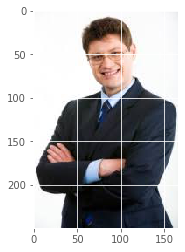

In [70]:
plt.imshow(img1)
plt.show()

In [68]:
prediction("download.jpeg")

('no_knife', 0.9563362)

In [75]:
img2 = plt.imread("download (1).jpeg")

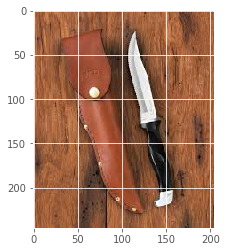

In [76]:
plt.imshow(img2)
plt.show()

In [78]:
prediction("download (1).jpeg")

('knife', 0.8345015)